In [1]:
from utils.epg import *
import matplotlib.pyplot as plt
from copy import copy
cmap = copy(plt.cm.get_cmap("jet"))
from scipy.optimize import least_squares

In [2]:
degree = r"${}^{\circ}$"
GeV = "GeV"
GeV2 = "GeV"+r"${}^{2}$"
GeVc = "GeV/c"
GeVc2 = "(GeV/c)"+r"${}^{2}$"

In [3]:
import matplotlib
# initial settings
pgf_with_latex = {
		"pgf.texsystem": "pdflatex",
		"text.usetex": True,            # use LaTeX to write all text
		"font.family": "sans-serif",         
		"font.sans-serif": "Helvetica",
		"font.size": 25,				# default font size
		"axes.labelsize": 24,			# x and y label size
		"axes.titlesize": 24,           # subfigure title size, i.e. title size when one figure
		"legend.fontsize": 22,			# legend size
		"xtick.labelsize": 23,			# x axis tick label size
		"ytick.labelsize": 23,			# y axis tick label 
		"figure.titlesize": 25,         # Figure title size, useful when you have multiple plots in one canvas.
		"pgf.preamble": r"\usepackage{xcolor}",     # xcolor for colours
		"figure.autolayout": True
}
matplotlib.rcParams.update(pgf_with_latex)

def nphistmean(hist, bins):
    s=0
    for i in range(len(hist)):
        s += hist[i] * ((bins[i] + bins[i+1]) / 2) 
    mean = s / np.sum(hist)
    return mean

In [4]:
def smearingDVCS4(df_epg, sigma = 0, sigma2 = 0, sigma3 = 0):
    #set up dvcs variables
    df_epg = copy(df_epg)

    ele = [df_epg['Epx'], df_epg['Epy'], df_epg['Epz']]
#     df_epg.loc[:, 'Ep'] = mag(ele)
#     df_epg.loc[:, 'Ee'] = getEnergy(ele, me)
#     df_epg.loc[:, 'Etheta'] = getTheta(ele)
#     df_epg.loc[:, 'Ephi'] = getPhi(ele)

    df_epg.loc[df_epg.Psector<7, 'Pp'] = np.random.normal(1, sigma, len(df_epg.loc[df_epg.Psector<7]))*df_epg.loc[df_epg.Psector<7, 'Pp']
    df_epg.loc[df_epg.Psector<7, 'Pe'] = np.sqrt(df_epg.loc[df_epg.Psector<7, 'Pp']**2+M**2)
    df_epg.loc[df_epg.Psector<7, 'Ptheta'] = np.random.normal(0, sigma2, len(df_epg.loc[df_epg.Psector<7])) + df_epg.loc[df_epg.Psector<7, 'Ptheta']
    df_epg.loc[df_epg.Psector>7, 'Pphi'] = np.random.normal(0, np.abs(sigma3/np.sin(np.radians(df_epg.loc[:, "Ptheta"]))), len(df_epg.loc[df_epg.Psector<7])) + df_epg.loc[df_epg.Psector<7, 'Pphi']
    df_epg.loc[:, "Ppx"] = df_epg.loc[:, "Pp"]*np.sin(np.radians(df_epg.loc[:, "Ptheta"]))*np.cos(np.radians(df_epg.loc[:, "Pphi"]))
    df_epg.loc[:, "Ppy"] = df_epg.loc[:, "Pp"]*np.sin(np.radians(df_epg.loc[:, "Ptheta"]))*np.sin(np.radians(df_epg.loc[:, "Pphi"]))
    df_epg.loc[:, "Ppz"] = df_epg.loc[:, "Pp"]*np.cos(np.radians(df_epg.loc[:, "Ptheta"]))
    pro = [df_epg['Ppx'], df_epg['Ppy'], df_epg['Ppz']]

#     df_epg.loc[:, 'Gp'] = np.random.normal(1, sigma, len(df_epg))*df_epg.loc[:, 'Gp']
#     df_epg.loc[:, 'Ge'] = df_epg.loc[:, 'Gp']
# #     df_epg.loc[:, 'Gtheta'] = getTheta(gam)
# #     df_epg.loc[:, 'Gphi'] = getPhi(gam)
#     df_epg.loc[:, "Gpx"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.cos(np.radians(df_epg.loc[:, "Gphi"]))
#     df_epg.loc[:, "Gpy"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.sin(np.radians(df_epg.loc[:, "Gphi"]))
#     df_epg.loc[:, "Gpz"] = df_epg.loc[:, "Gp"]*np.cos(np.radians(df_epg.loc[:, "Gtheta"]))
    gam = [df_epg['Gpx'], df_epg['Gpy'], df_epg['Gpz']]
    
    Ppt = mag([df_epg['Ppx'], df_epg['Ppy'], 0])

    VGS = [-df_epg['Epx'], -df_epg['Epy'], pbeam - df_epg['Epz']]
    v3l = cross(beam, ele)
    v3h = cross(pro, VGS)
    v3g = cross(VGS, gam)
    VmissG = [-df_epg["Epx"] - df_epg["Ppx"], -df_epg["Epy"] - df_epg["Ppy"],
              pbeam - df_epg["Epz"] - df_epg["Ppz"]]
    VmissP = [-(df_epg["Epx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Gpy"]),
              -(-pbeam + df_epg["Epz"] + df_epg["Gpz"])]
    Vmiss = [-(df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"]),
             -(-pbeam + df_epg["Epz"] + df_epg["Ppz"] + df_epg["Gpz"])]
    costheta = cosTheta(VGS, gam)

    df_epg.loc[:, 'Mpx'], df_epg.loc[:, 'Mpy'], df_epg.loc[:, 'Mpz'] = Vmiss

    # binning kinematics
    df_epg.loc[:,'Q2'] = -((ebeam - df_epg['Ee'])**2 - mag2(VGS))
    df_epg.loc[:,'nu'] = (ebeam - df_epg['Ee'])
    df_epg.loc[:,'y'] = df_epg['nu']/ebeam
    df_epg.loc[:,'xB'] = df_epg['Q2'] / 2.0 / M / df_epg['nu']
    df_epg.loc[:,'t1'] = 2 * M * (df_epg['Pe'] - M)
    df_epg.loc[:,'t2'] = (M * df_epg['Q2'] + 2 * M * df_epg['nu'] * (df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta))\
    / (M + df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta)
    df_epg.loc[:,'W'] = np.sqrt(np.maximum(0, (ebeam + M - df_epg['Ee'])**2 - mag2(VGS)))

    # trento angles
    df_epg.loc[:,'phi1'] = angle(v3l, v3h)
    df_epg.loc[:,'phi1'] = np.where(dot(v3l, pro) > 0, 360.0 -
                              df_epg['phi1'], df_epg['phi1'])
    df_epg.loc[:,'phi2'] = angle(v3l, v3g)
    df_epg.loc[:,'phi2'] = np.where(dot(v3l, gam) <
                              0, 360.0 - df_epg['phi2'], df_epg['phi2'])

    # exclusivity variables
    df_epg.loc[:,'MM2_epg'] = (-M - ebeam + df_epg["Ee"] +
                         df_epg["Pe"] + df_epg["Ge"])**2 - mag2(Vmiss)
    df_epg.loc[:,'ME_epg'] = (M + ebeam - df_epg["Ee"] - df_epg["Pe"] - df_epg["Ge"])
    df_epg.loc[:,'MM2_ep'] = (-M - ebeam + df_epg["Ee"] + df_epg["Pe"])**2 - mag2(VmissG)
    df_epg.loc[:,'MM2_eg'] = (-M - ebeam + df_epg["Ee"] + df_epg["Ge"])**2 - mag2(VmissP)
    df_epg.loc[:,'MPt'] = np.sqrt((df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"])**2 +
                            (df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"])**2)
    df_epg.loc[:,'coneAngle'] = angle(ele, gam)
    df_epg.loc[:,'reconGam'] = angle(gam, VmissG)
    df_epg.loc[:,'coplanarity'] = angle(v3h, v3g)
    
    return df_epg

In [5]:
def smearingDVPi0P4(df_epgg, sigma = 0, sigma2 = 0, sigma3 = 0):
    #set up pi0 variables
    df_epgg = copy(df_epgg)

    # useful objects
    ele = [df_epgg['Epx'], df_epgg['Epy'], df_epgg['Epz']]
#     df_epgg.loc[:, 'Ep'] = mag(ele)
#     df_epgg.loc[:, 'Ee'] = getEnergy(ele, me)
#     df_epgg.loc[:, 'Etheta'] = getTheta(ele)
#     df_epgg.loc[:, 'Ephi'] = getPhi(ele)

    df_epgg.loc[df_epgg.Psector<7, 'Pp'] = np.random.normal(1, sigma, len(df_epgg.loc[df_epgg.Psector<7]))*df_epgg.loc[df_epgg.Psector<7, 'Pp']
    df_epgg.loc[df_epgg.Psector<7, 'Pe'] = np.sqrt(df_epgg.loc[df_epgg.Psector<7, 'Pp']**2+M**2)
    df_epgg.loc[df_epgg.Psector<7, 'Ptheta'] = np.random.normal(0, sigma2, len(df_epgg.loc[df_epgg.Psector<7])) + df_epgg.loc[df_epgg.Psector<7, 'Ptheta']
    df_epgg.loc[df_epgg.Psector>7, 'Pphi'] = np.random.normal(0, np.abs(sigma3/np.sin(np.radians(df_epgg.loc[:, "Ptheta"]))), len(df_epgg.loc[df_epgg.Psector<7]))+df_epgg.loc[df_epgg.Psector<7, 'Pphi']
    df_epgg.loc[:, "Ppx"] = df_epgg.loc[:, "Pp"]*np.sin(np.radians(df_epgg.loc[:, "Ptheta"]))*np.cos(np.radians(df_epgg.loc[:, "Pphi"]))
    df_epgg.loc[:, "Ppy"] = df_epgg.loc[:, "Pp"]*np.sin(np.radians(df_epgg.loc[:, "Ptheta"]))*np.sin(np.radians(df_epgg.loc[:, "Pphi"]))
    df_epgg.loc[:, "Ppz"] = df_epgg.loc[:, "Pp"]*np.cos(np.radians(df_epgg.loc[:, "Ptheta"]))
    pro = [df_epgg['Ppx'], df_epgg['Ppy'], df_epgg['Ppz']]

    gam = [df_epgg['Gpx'], df_epgg['Gpy'], df_epgg['Gpz']]
#     df_epgg.loc[:, 'Gp'] = mag(gam)
#     df_epgg.loc[:, 'Ge'] = getEnergy(gam, 0)
#     df_epgg.loc[:, 'Gtheta'] = getTheta(gam)
#     df_epgg.loc[:, 'Gphi'] = getPhi(gam)

    gam2 = [df_epgg['Gpx2'], df_epgg['Gpy2'], df_epgg['Gpz2']]
#     df_epgg.loc[:, 'Gp2'] = mag(gam2)
#     df_epgg.loc[:,'Ge2'] = getEnergy(gam2, 0)
#     df_epgg.loc[:, 'Gtheta2'] = getTheta(gam2)
#     df_epgg.loc[:, 'Gphi2'] = getPhi(gam2)

    pi0 = vecAdd(gam, gam2)
    VGS = [-df_epgg['Epx'], -df_epgg['Epy'], pbeam - df_epgg['Epz']]
    v3l = cross(beam, ele)
    v3h = cross(pro, VGS)
    v3g = cross(VGS, gam)
    v3pi0 = cross(VGS, pi0)

    VmissPi0 = [-df_epgg["Epx"] - df_epgg["Ppx"], -df_epgg["Epy"] -
                df_epgg["Ppy"], pbeam - df_epgg["Epz"] - df_epgg["Ppz"]]
    VmissP = [-df_epgg["Epx"] - df_epgg["Gpx"] - df_epgg["Gpx2"], -df_epgg["Epy"] -
                df_epgg["Gpy"] - df_epgg["Gpy2"], pbeam - df_epgg["Epz"] - df_epgg["Gpz"] - df_epgg["Gpz2"]]
    Vmiss = [-df_epgg["Epx"] - df_epgg["Ppx"] - df_epgg["Gpx"] - df_epgg["Gpx2"],
                -df_epgg["Epy"] - df_epgg["Ppy"] - df_epgg["Gpy"] - df_epgg["Gpy2"],
                pbeam - df_epgg["Epz"] - df_epgg["Ppz"] - df_epgg["Gpz"] - df_epgg["Gpz2"]]
    costheta = cosTheta(VGS, gam)

    df_epgg.loc[:, 'Mpx'], df_epgg.loc[:, 'Mpy'], df_epgg.loc[:, 'Mpz'] = Vmiss

    # binning kinematics
    df_epgg.loc[:,'Q2'] = -((ebeam - df_epgg['Ee'])**2 - mag2(VGS))
    df_epgg.loc[:,'nu'] = (ebeam - df_epgg['Ee'])
    df_epgg.loc[:,'xB'] = df_epgg['Q2'] / 2.0 / M / df_epgg['nu']
    df_epgg.loc[:,'t1'] = 2 * M * (df_epgg['Pe'] - M)
    df_epgg.loc[:,'t2'] = (M * df_epgg['Q2'] + 2 * M * df_epgg['nu'] * (df_epgg['nu'] - np.sqrt(df_epgg['nu'] * df_epgg['nu'] + df_epgg['Q2']) * costheta))\
    / (M + df_epgg['nu'] - np.sqrt(df_epgg['nu'] * df_epgg['nu'] + df_epgg['Q2']) * costheta)
    df_epgg.loc[:,'W'] = np.sqrt(np.maximum(0, (ebeam + M - df_epgg['Ee'])**2 - mag2(VGS)))
    df_epgg.loc[:,'MPt'] = np.sqrt((df_epgg["Epx"] + df_epgg["Ppx"] + df_epgg["Gpx"] + df_epgg["Gpx2"])**2 +
                             (df_epgg["Epy"] + df_epgg["Ppy"] + df_epgg["Gpy"] + df_epgg["Gpy2"])**2)
    # trento angles
    df_epgg.loc[:,'phi1'] = angle(v3l, v3h)
    df_epgg.loc[:,'phi1'] = np.where(dot(v3l, pro) > 0, 360.0 -
                              df_epgg['phi1'], df_epgg['phi1'])
    df_epgg.loc[:,'phi2'] = angle(v3l, v3g)
    df_epgg.loc[:,'phi2'] = np.where(dot(v3l, gam) <
                              0, 360.0 - df_epgg['phi2'], df_epgg['phi2'])

    # exclusivity variables
    df_epgg.loc[:,'MM2_ep'] = (-M - ebeam + df_epgg["Ee"] +
                         df_epgg["Pe"])**2 - mag2(VmissPi0)
    df_epgg.loc[:,'MM2_egg'] = (-M - ebeam + df_epgg["Ee"] +
                         df_epgg["Ge"] + df_epgg["Ge2"])**2 - mag2(VmissP)
    df_epgg.loc[:,'MM2_epgg'] = (-M - ebeam + df_epgg["Ee"] + df_epgg["Pe"] +
                         df_epgg["Ge"] + df_epgg["Ge2"])**2 - mag2(Vmiss)
    df_epgg.loc[:,'ME_epgg'] = (M + ebeam - df_epgg["Ee"] - df_epgg["Pe"] - df_epgg["Ge"] - df_epgg["Ge2"])
    df_epgg.loc[:,'Mpi0'] = pi0InvMass(gam, gam2)
    df_epgg.loc[:,'reconPi'] = angle(VmissPi0, pi0)
    df_epgg.loc[:,"Pie"] = df_epgg['Ge'] + df_epgg['Ge2']
    df_epgg.loc[:,'coplanarity'] = angle(v3h, v3pi0)
    df_epgg.loc[:,'coneAngle1'] = angle(ele, gam)
    df_epgg.loc[:,'coneAngle2'] = angle(ele, gam2)

    df_epgg.loc[:, "closeness"] = np.abs(df_epgg.loc[:, "Mpi0"] - .1349766)

    return df_epgg

In [6]:
def correctDVCS4(df_epg, correction=0, correction2 =0, correction3=0):
    #set up dvcs variables
    df_epg = copy(df_epg)

    ele = [df_epg['Epx'], df_epg['Epy'], df_epg['Epz']]
#     df_epg.loc[:, 'Ep'] = mag(ele)
#     df_epg.loc[:, 'Ee'] = getEnergy(ele, me)
#     df_epg.loc[:, 'Etheta'] = getTheta(ele)
#     df_epg.loc[:, 'Ephi'] = getPhi(ele)

    df_epg.loc[df_epg.Psector<7, 'Pp'] = df_epg.loc[df_epg.Psector<7, 'Pp'] + correction
    df_epg.loc[df_epg.Psector<7, 'Pe'] = np.sqrt(df_epg.loc[df_epg.Psector<7, 'Pp']**2+M**2)
    df_epg.loc[df_epg.Psector<7, 'Ptheta'] = df_epg.loc[df_epg.Psector<7, 'Ptheta'] + correction2
    df_epg.loc[df_epg.Psector<7, 'Pphi'] = df_epg.loc[df_epg.Psector<7, 'Pphi'] + correction3
    df_epg.loc[:, "Ppx"] = df_epg.loc[:, "Pp"]*np.sin(np.radians(df_epg.loc[:, "Ptheta"]))*np.cos(np.radians(df_epg.loc[:, "Pphi"]))
    df_epg.loc[:, "Ppy"] = df_epg.loc[:, "Pp"]*np.sin(np.radians(df_epg.loc[:, "Ptheta"]))*np.sin(np.radians(df_epg.loc[:, "Pphi"]))
    df_epg.loc[:, "Ppz"] = df_epg.loc[:, "Pp"]*np.cos(np.radians(df_epg.loc[:, "Ptheta"]))
    pro = [df_epg['Ppx'], df_epg['Ppy'], df_epg['Ppz']]
    
#     df_epg.loc[df_epg.Gsector>7, 'Gp'] = df_epg.loc[df_epg.Gsector>7, 'Gp'] + 0.25
#     df_epg.loc[df_epg.Gsector>7, 'Ge'] = df_epg.loc[df_epg.Gsector>7, 'Ge'] + 0.25
# #     df_epg.loc[:, 'Gtheta'] = getTheta(gam)
# #     df_epg.loc[:, 'Gphi'] = getPhi(gam)
#     df_epg.loc[:, "Gpx"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.cos(np.radians(df_epg.loc[:, "Gphi"]))
#     df_epg.loc[:, "Gpy"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.sin(np.radians(df_epg.loc[:, "Gphi"]))
#     df_epg.loc[:, "Gpz"] = df_epg.loc[:, "Gp"]*np.cos(np.radians(df_epg.loc[:, "Gtheta"]))
    gam = [df_epg['Gpx'], df_epg['Gpy'], df_epg['Gpz']]

    Ppt = mag([df_epg['Ppx'], df_epg['Ppy'], 0])

    VGS = [-df_epg['Epx'], -df_epg['Epy'], pbeam - df_epg['Epz']]
    v3l = cross(beam, ele)
    v3h = cross(pro, VGS)
    v3g = cross(VGS, gam)
    VmissG = [-df_epg["Epx"] - df_epg["Ppx"], -df_epg["Epy"] - df_epg["Ppy"],
              pbeam - df_epg["Epz"] - df_epg["Ppz"]]
    VmissP = [-(df_epg["Epx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Gpy"]),
              -(-pbeam + df_epg["Epz"] + df_epg["Gpz"])]
    Vmiss = [-(df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"]),
             -(-pbeam + df_epg["Epz"] + df_epg["Ppz"] + df_epg["Gpz"])]
    costheta = cosTheta(VGS, gam)

    df_epg.loc[:, 'Mpx'], df_epg.loc[:, 'Mpy'], df_epg.loc[:, 'Mpz'] = Vmiss

    # binning kinematics
    df_epg.loc[:,'Q2'] = -((ebeam - df_epg['Ee'])**2 - mag2(VGS))
    df_epg.loc[:,'nu'] = (ebeam - df_epg['Ee'])
    df_epg.loc[:,'y'] = df_epg['nu']/ebeam
    df_epg.loc[:,'xB'] = df_epg['Q2'] / 2.0 / M / df_epg['nu']
    df_epg.loc[:,'t1'] = 2 * M * (df_epg['Pe'] - M)
    df_epg.loc[:,'t2'] = (M * df_epg['Q2'] + 2 * M * df_epg['nu'] * (df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta))\
    / (M + df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta)
    df_epg.loc[:,'W'] = np.sqrt(np.maximum(0, (ebeam + M - df_epg['Ee'])**2 - mag2(VGS)))

    # trento angles
    df_epg.loc[:,'phi1'] = angle(v3l, v3h)
    df_epg.loc[:,'phi1'] = np.where(dot(v3l, pro) > 0, 360.0 -
                              df_epg['phi1'], df_epg['phi1'])
    df_epg.loc[:,'phi2'] = angle(v3l, v3g)
    df_epg.loc[:,'phi2'] = np.where(dot(v3l, gam) <
                              0, 360.0 - df_epg['phi2'], df_epg['phi2'])

    # exclusivity variables
    df_epg.loc[:,'MM2_epg'] = (-M - ebeam + df_epg["Ee"] +
                         df_epg["Pe"] + df_epg["Ge"])**2 - mag2(Vmiss)
    df_epg.loc[:,'ME_epg'] = (M + ebeam - df_epg["Ee"] - df_epg["Pe"] - df_epg["Ge"])
    df_epg.loc[:,'MM2_ep'] = (-M - ebeam + df_epg["Ee"] + df_epg["Pe"])**2 - mag2(VmissG)
    df_epg.loc[:,'MM2_eg'] = (-M - ebeam + df_epg["Ee"] + df_epg["Ge"])**2 - mag2(VmissP)
    df_epg.loc[:,'MPt'] = np.sqrt((df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"])**2 +
                            (df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"])**2)
    df_epg.loc[:,'coneAngle'] = angle(ele, gam)
    df_epg.loc[:,'reconGam'] = angle(gam, VmissG)
    df_epg.loc[:,'coplanarity'] = angle(v3h, v3g)
    
    return df_epg


In [7]:
def correctDVPi0P4(df_epgg, correction=0, correction2 =0, correction3=0):
    #set up pi0 variables
    df_epgg = copy(df_epgg)

    # useful objects
    ele = [df_epgg['Epx'], df_epgg['Epy'], df_epgg['Epz']]
#     df_epgg.loc[:, 'Ep'] = mag(ele)
#     df_epgg.loc[:, 'Ee'] = getEnergy(ele, me)
#     df_epgg.loc[:, 'Etheta'] = getTheta(ele)
#     df_epgg.loc[:, 'Ephi'] = getPhi(ele)

    df_epgg.loc[df_epgg.Psector<7, 'Pp'] = df_epgg.loc[df_epgg.Psector<7, 'Pp'] + correction
    df_epgg.loc[df_epgg.Psector<7, 'Pe'] = np.sqrt(df_epgg.loc[df_epgg.Psector<7, 'Pp']**2+M**2)
    df_epgg.loc[df_epgg.Psector<7, 'Ptheta'] = df_epgg.loc[df_epgg.Psector<7, 'Ptheta'] + correction2
    df_epgg.loc[df_epgg.Psector<7, 'Pphi'] = df_epgg.loc[df_epgg.Psector<7, 'Pphi'] + correction3
    df_epgg.loc[:, "Ppx"] = df_epgg.loc[:, "Pp"]*np.sin(np.radians(df_epgg.loc[:, "Ptheta"]))*np.cos(np.radians(df_epgg.loc[:, "Pphi"]))
    df_epgg.loc[:, "Ppy"] = df_epgg.loc[:, "Pp"]*np.sin(np.radians(df_epgg.loc[:, "Ptheta"]))*np.sin(np.radians(df_epgg.loc[:, "Pphi"]))
    df_epgg.loc[:, "Ppz"] = df_epgg.loc[:, "Pp"]*np.cos(np.radians(df_epgg.loc[:, "Ptheta"]))
    pro = [df_epgg['Ppx'], df_epgg['Ppy'], df_epgg['Ppz']]

    gam = [df_epgg['Gpx'], df_epgg['Gpy'], df_epgg['Gpz']]
#     df_epgg.loc[:, 'Gp'] = mag(gam)
#     df_epgg.loc[:, 'Ge'] = getEnergy(gam, 0)
#     df_epgg.loc[:, 'Gtheta'] = getTheta(gam)
#     df_epgg.loc[:, 'Gphi'] = getPhi(gam)

    gam2 = [df_epgg['Gpx2'], df_epgg['Gpy2'], df_epgg['Gpz2']]
#     df_epgg.loc[:, 'Gp2'] = mag(gam2)
#     df_epgg.loc[:,'Ge2'] = getEnergy(gam2, 0)
#     df_epgg.loc[:, 'Gtheta2'] = getTheta(gam2)
#     df_epgg.loc[:, 'Gphi2'] = getPhi(gam2)

    pi0 = vecAdd(gam, gam2)
    VGS = [-df_epgg['Epx'], -df_epgg['Epy'], pbeam - df_epgg['Epz']]
    v3l = cross(beam, ele)
    v3h = cross(pro, VGS)
    v3g = cross(VGS, gam)
    v3pi0 = cross(VGS, pi0)

    VmissPi0 = [-df_epgg["Epx"] - df_epgg["Ppx"], -df_epgg["Epy"] -
                df_epgg["Ppy"], pbeam - df_epgg["Epz"] - df_epgg["Ppz"]]
    VmissP = [-df_epgg["Epx"] - df_epgg["Gpx"] - df_epgg["Gpx2"], -df_epgg["Epy"] -
                df_epgg["Gpy"] - df_epgg["Gpy2"], pbeam - df_epgg["Epz"] - df_epgg["Gpz"] - df_epgg["Gpz2"]]
    Vmiss = [-df_epgg["Epx"] - df_epgg["Ppx"] - df_epgg["Gpx"] - df_epgg["Gpx2"],
                -df_epgg["Epy"] - df_epgg["Ppy"] - df_epgg["Gpy"] - df_epgg["Gpy2"],
                pbeam - df_epgg["Epz"] - df_epgg["Ppz"] - df_epgg["Gpz"] - df_epgg["Gpz2"]]
    costheta = cosTheta(VGS, gam)

    df_epgg.loc[:, 'Mpx'], df_epgg.loc[:, 'Mpy'], df_epgg.loc[:, 'Mpz'] = Vmiss

    # binning kinematics
    df_epgg.loc[:,'Q2'] = -((ebeam - df_epgg['Ee'])**2 - mag2(VGS))
    df_epgg.loc[:,'nu'] = (ebeam - df_epgg['Ee'])
    df_epgg.loc[:,'xB'] = df_epgg['Q2'] / 2.0 / M / df_epgg['nu']
    df_epgg.loc[:,'t1'] = 2 * M * (df_epgg['Pe'] - M)
    df_epgg.loc[:,'t2'] = (M * df_epgg['Q2'] + 2 * M * df_epgg['nu'] * (df_epgg['nu'] - np.sqrt(df_epgg['nu'] * df_epgg['nu'] + df_epgg['Q2']) * costheta))\
    / (M + df_epgg['nu'] - np.sqrt(df_epgg['nu'] * df_epgg['nu'] + df_epgg['Q2']) * costheta)
    df_epgg.loc[:,'W'] = np.sqrt(np.maximum(0, (ebeam + M - df_epgg['Ee'])**2 - mag2(VGS)))
    df_epgg.loc[:,'MPt'] = np.sqrt((df_epgg["Epx"] + df_epgg["Ppx"] + df_epgg["Gpx"] + df_epgg["Gpx2"])**2 +
                             (df_epgg["Epy"] + df_epgg["Ppy"] + df_epgg["Gpy"] + df_epgg["Gpy2"])**2)
    # trento angles
    df_epgg.loc[:,'phi1'] = angle(v3l, v3h)
    df_epgg.loc[:,'phi1'] = np.where(dot(v3l, pro) > 0, 360.0 -
                              df_epgg['phi1'], df_epgg['phi1'])
    df_epgg.loc[:,'phi2'] = angle(v3l, v3g)
    df_epgg.loc[:,'phi2'] = np.where(dot(v3l, gam) <
                              0, 360.0 - df_epgg['phi2'], df_epgg['phi2'])

    # exclusivity variables
    df_epgg.loc[:,'MM2_ep'] = (-M - ebeam + df_epgg["Ee"] +
                         df_epgg["Pe"])**2 - mag2(VmissPi0)
    df_epgg.loc[:,'MM2_egg'] = (-M - ebeam + df_epgg["Ee"] +
                         df_epgg["Ge"] + df_epgg["Ge2"])**2 - mag2(VmissP)
    df_epgg.loc[:,'MM2_epgg'] = (-M - ebeam + df_epgg["Ee"] + df_epgg["Pe"] +
                         df_epgg["Ge"] + df_epgg["Ge2"])**2 - mag2(Vmiss)
    df_epgg.loc[:,'ME_epgg'] = (M + ebeam - df_epgg["Ee"] - df_epgg["Pe"] - df_epgg["Ge"] - df_epgg["Ge2"])
    df_epgg.loc[:,'Mpi0'] = pi0InvMass(gam, gam2)
    df_epgg.loc[:,'reconPi'] = angle(VmissPi0, pi0)
    df_epgg.loc[:,"Pie"] = df_epgg['Ge'] + df_epgg['Ge2']
    df_epgg.loc[:,'coplanarity'] = angle(v3h, v3pi0)
    df_epgg.loc[:,'coneAngle1'] = angle(ele, gam)
    df_epgg.loc[:,'coneAngle2'] = angle(ele, gam2)

    df_epgg.loc[:, "closeness"] = np.abs(df_epgg.loc[:, "Mpi0"] - .1349766)

    return df_epgg

In [51]:
parent_MC = "/Volumes/Extreme SSD/nov2021/convPkl_FDrevisited/inb/dvcs/"
parent_MC_bkg1g = "/Volumes/Extreme SSD/nov2021/convPkl_FDrevisited/inb/bkg_1g/"
parent_MC_bkg2g = "/Volumes/Extreme SSD/nov2021/convPkl_FDrevisited/inb/bkg_2g/"
parent_exp = "/Volumes/Extreme SSD/Jan2022/convPkl/exp/"
# parent_exp = "/Volumes/Extreme SSD/nov2021/convPkl_FDrevisited/inb/exp/"

#epg Exp
exp_1g_corr = pd.read_pickle(parent_exp + "dvcs.pkl")

#dvcs Rec
df_3987_corr = pd.read_pickle(parent_MC + "3987_0.pkl")

#bkg1g Rec
df_4076_1g_corr = pd.read_pickle(parent_MC_bkg1g + "4076_0.pkl")
#bkg2g Rec
df_4076_2g_corr = pd.read_pickle(parent_MC_bkg2g + "4076_0.pkl")
#bkg2g Exp
exp_2g_corr = pd.read_pickle(parent_exp + "pi0.pkl")

In [52]:
epgExpInb = copy(exp_1g_corr)
epgExpInbCDFT = epgExpInb.loc[exp_1g_corr.config == 3]
epgExpInbCD = epgExpInb.loc[epgExpInb.config == 2]
epgExpInbFD = epgExpInb.loc[epgExpInb.config == 1]

In [53]:
pi0ExpInb = copy(exp_2g_corr)
dvcsSimInb = df_3987_corr
bkgSimInb = df_4076_1g_corr
pi0SimInb = df_4076_2g_corr

In [54]:
epgExpInbCDFT = epgExpInb.loc[epgExpInb.config == 3]
dvcsSimInbCDFT = dvcsSimInb.loc[dvcsSimInb.config == 3]
bkgSimInbCDFT = bkgSimInb.loc[bkgSimInb.config == 3]
pi0ExpInbCDFT = pi0ExpInb.loc[(pi0ExpInb.config == 3)& (pi0ExpInb.Pp < 0.8)]
pi0SimInbCDFT = pi0SimInb.loc[(pi0SimInb.config == 3)& (pi0SimInb.Pp < 0.8)]

epgExpInbCD = epgExpInb.loc[epgExpInb.config == 2]
dvcsSimInbCD = dvcsSimInb.loc[dvcsSimInb.config == 2]
bkgSimInbCD = bkgSimInb.loc[bkgSimInb.config == 2]
pi0ExpInbCD = pi0ExpInb.loc[(pi0ExpInb.config == 2)& (pi0ExpInb.Pp < 0.8)]
pi0SimInbCD = pi0SimInb.loc[(pi0SimInb.config == 2)& (pi0SimInb.Pp < 0.8)]

epgExpInbFD = epgExpInb.loc[epgExpInb.config == 1]
dvcsSimInbFD = dvcsSimInb.loc[dvcsSimInb.config == 1]
bkgSimInbFD = bkgSimInb.loc[bkgSimInb.config == 1]
pi0ExpInbFD = pi0ExpInb.loc[(pi0ExpInb.config == 1)& (pi0ExpInb.Pp < 0.8)]
pi0SimInbFD = pi0SimInb.loc[(pi0SimInb.config == 1)& (pi0SimInb.Pp < 0.8)]

In [55]:
contInbCD = len(pi0ExpInbCD)*len(bkgSimInbCD)/len(pi0SimInbCD)/len(epgExpInbCD)
contInbFD = len(pi0ExpInbFD)*len(bkgSimInbFD)/len(pi0SimInbFD)/len(epgExpInbFD)
contInbCDFT = len(pi0ExpInbCDFT)*len(bkgSimInbCDFT)/len(pi0SimInbCDFT)/len(epgExpInbCDFT)
contInb = len(pi0ExpInb)*len(bkgSimInb)/len(pi0SimInb)/len(epgExpInb)

In [56]:
print(contInbFD, contInbCD, contInbCDFT)

0.3061225520355358 0.09402158892287202 0.0028291401178065015


In [57]:
print(len(epgExpInbFD), len(epgExpInbCD), len(epgExpInbCDFT))

42175 94489 94475


In [58]:
print(len(pi0ExpInbFD), len(pi0ExpInbCD), len(pi0ExpInbCDFT))

24085 25110 3131


In [59]:
epgExpInbFD = epgExpInbFD.loc[epgExpInbFD.Psector != epgExpInbFD.Gsector]

Pp 0.635606548697847
reconGam 0.5788147668404773
coplanarity 6.324751993826327
Ptheta 28.86483473353778
MM2_epg -0.0011063381346142754
Pphi 10.970481479345674
MM2_ep -0.0032718713466703586
MPt 0.07507938507166408


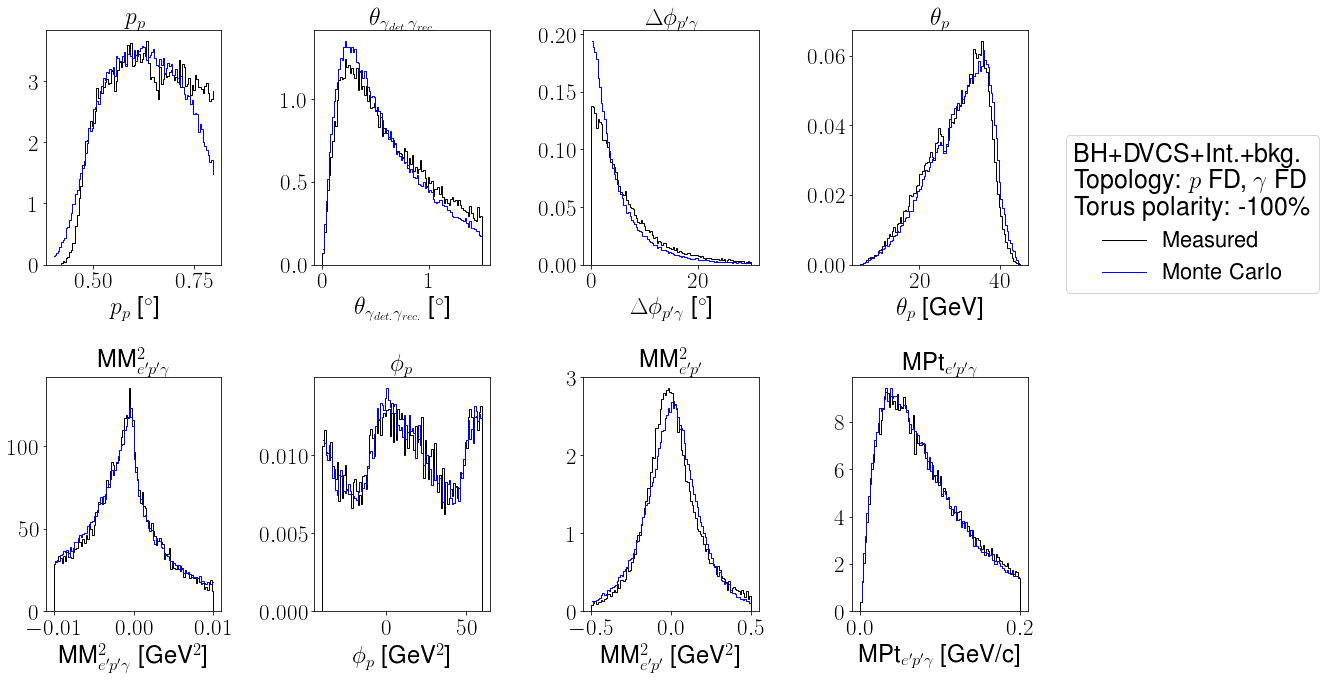

<Figure size 432x288 with 0 Axes>

In [60]:
df2 = bkgSimInbFD
df1 = dvcsSimInbFD
df3 = epgExpInbFD

df2 = smearingDVCS4(bkgSimInbFD, 0.075, 0, 0)
df1 = smearingDVCS4(dvcsSimInbFD, 0.075, 0, 0)
# df3 = correctDVCS4(df3, 0.02*(1/(1+np.exp(-(df3.Pp-0.55)/0.01))), 0, 0)

df3 = df3.loc[df3.Psector != df3.Gsector]
df2 = df2.loc[df2.Psector != df2.Gsector]
df1 = df1.loc[df1.Psector != df1.Gsector]

# Sector = 2
# df3 = df3.loc[df3.Psector == Sector, :]
# df2 = df2.loc[df2.Psector == Sector, :]
# df1 = df1.loc[df1.Psector == Sector, :]

df3 = df3.loc[(df3.Pp > 0.4) & (df3.Pp<0.8) & (df3.Ptheta > 5) & (df3.Ptheta < 45) ]#& (df3.Pband == "lower")]
df2 = df2.loc[(df2.Pp > 0.4) & (df2.Pp<0.8) & (df2.Ptheta > 5) & (df2.Ptheta < 45) ]#& (df2.Pband == "lower")]
df1 = df1.loc[(df1.Pp > 0.4) & (df1.Pp<0.8) & (df1.Ptheta > 5) & (df1.Ptheta < 45) ]#& (df1.Pband == "lower")]

varstoplot = ["Pp", "reconGam", "coplanarity", "Ptheta", "MM2_epg", "Pphi", "MM2_ep", "MPt"]
title = [r"$p_p$", r"$\theta_{\gamma_{det.}\gamma_{rec.}}$", r"$\Delta\phi_{p'\gamma}$" , r"$\theta_p$", "MM"+r"${}^{2}_{e'p'\gamma}$", "$\phi_p$", "MM"+r"${}^{2}_{e'p'}$", "MPt"+r"${}_{e'p'\gamma}$"]
unit = [degree, degree, degree, GeV, GeV2, GeV2, GeV2, GeVc]
binstarts = [10, 0, 0, -0.5, -0.01, -40,-0.5 , 0]
binends = [40, 1.5, 30, 1.2, 0.01, 60, 0.5, 0.2]
fig, axs = plt.subplots(2, 4, figsize = (15,10))
for yind in range(0, 2):
    for xind in range(0,4):
        ind = 4*yind + xind
        start = binstarts[ind]
        end = binends[ind]
        bins = 100#np.linspace(start, end, 101)
        if ind in [1, 2, 4, 5, 6, 7] :
            bins = np.linspace(start, end, 101)
        simDist_dvpi0, bins = np.histogram(df2[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(df1[varstoplot[ind]], bins, density = True)
        simDist = (1-contInbFD)*simDist_dvcs + contInbFD*simDist_dvpi0
        expDist, bins = np.histogram(df3[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        if ind == 0:
            axs[yind, xind].step(bincenters, expDist, where='mid',color='k', linewidth=1, label = 'Measured')           
            axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1, label = 'Monte Carlo')  
            axs[yind, xind].set_ylim(bottom = 0)
        else:
            axs[yind, xind].hist(df3[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
            axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
        print(varstoplot[ind], nphistmean(expDist - len(pi0ExpInbFD)/len(pi0SimInbFD)*simDist_dvpi0, bins))
        axs[yind, xind].set_title(title[ind])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
plt.tight_layout()
fig.legend(bbox_to_anchor = (1.25, 0.8), title = "BH+DVCS+Int.+bkg.\nTopology: "+r"$p$"+" FD, "+r"$\gamma$"+" FD\n"+"Torus polarity: -100\%")
plt.show()
plt.clf()

In [61]:
pi0ExpInbFD = pi0ExpInb.loc[(pi0ExpInb.config == 1)]
pi0SimInbFD = pi0SimInb.loc[(pi0SimInb.config == 1)]

<AxesSubplot:>

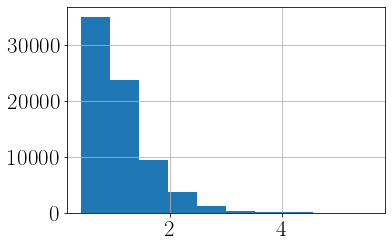

In [164]:
pi0ExpInbFD.Pp.hist()

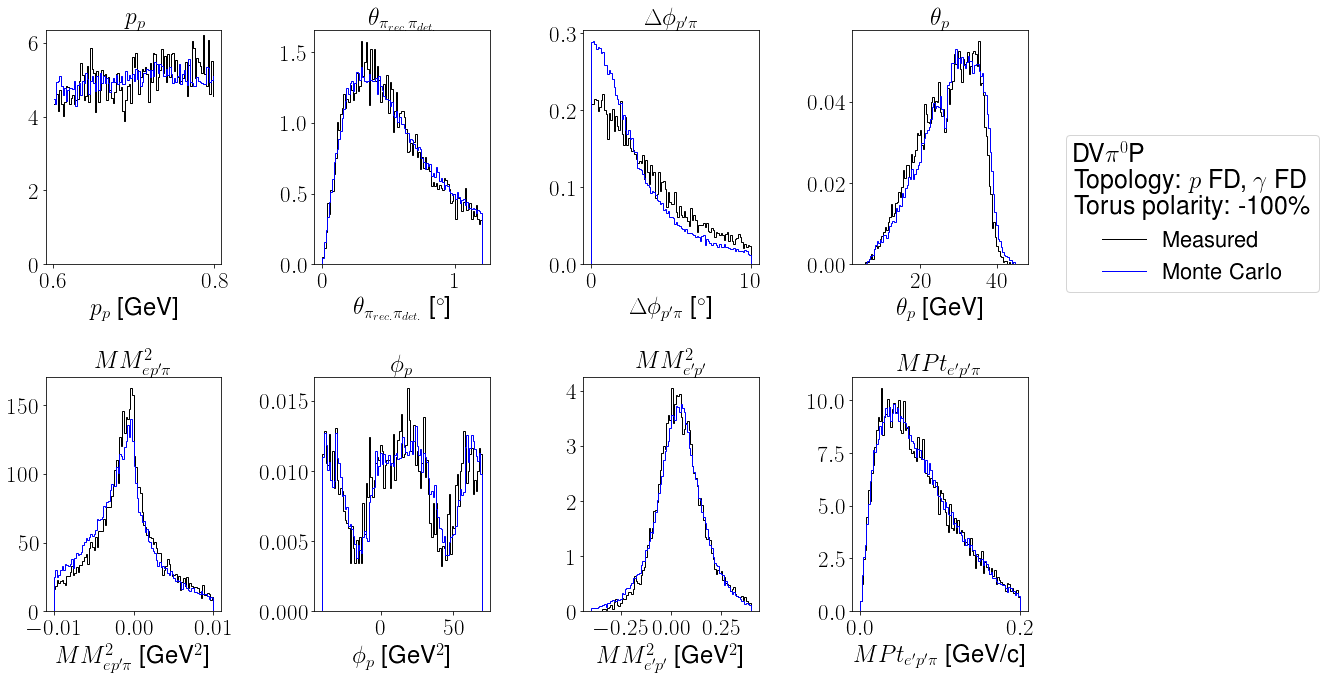

In [586]:
df2 = pi0SimInbFD
df3 = pi0ExpInbFD

df2 = smearingDVPi0P4(pi0SimInbFD, np.select([df2.Pp<1.3, (df2.Pp>=1.3) & (df2.Pp<1.9), df2.Pp>=1.9], [0.075, -7/120*df2.Pp+7*1.9/120+0.04, 0.04]), 0, 0)
x = df3.Pp
df3 = correctDVPi0P4(df3, np.select([(x<0.46),(x>=0.46)& (x<1.188), (x>=1.188)], [0.000164, p(x), -0.0100263]), 0, 0)
df3 = correctDVPi0P4(df3, 0.01, 0, 0)
df3 = df3.loc[df3.Psector != df3.Gsector]
df3 = df3.loc[df3.Psector != df3.Gsector2]
df2 = df2.loc[df2.Psector != df2.Gsector]
df2 = df2.loc[df2.Psector != df2.Gsector2]
df3 = df3.loc[(df3.Pp > 0.8) & (df3.Pp<0.8) & (df3.Ptheta<50)]
df2 = df2.loc[(df2.Pp > 0.8) & (df2.Pp<0.1) & (df2.Ptheta<50)]
# df3 = df3.loc[(df3.Pp > 0.5) & (df3.Pp<0.55) & (df3.Ptheta < 40)]# & (df3.Pband == "upper")]
# df2 = df2.loc[(df2.Pp > 0.5) & (df2.Pp<0.55) & (df2.Ptheta < 40)]# & (df2.Pband == "upper")]

# Sector = 2
# df3 = df3.loc[df3.Psector == Sector, :]
# df2 = df2.loc[df2.Psector == Sector, :]

varstoplot = ["Pp", "reconPi", "coplanarity", "Ptheta", "MM2_epgg", "Pphi", "MM2_ep", "MPt"]
title = [r"$p_p$", r"$\theta_{\pi_{rec.}\pi_{det.}}$", r"$\Delta\phi_{p'\pi}$", r"$\theta_p$", r"$MM^2_{ep'\pi}$", r"$\phi_p$", r"$MM^{2}_{e'p'}$", r"$MPt_{e'p'\pi}$" ]
unit = [GeV, degree, degree, GeV, GeV2, GeV2, GeV2, GeVc]
binstarts = [0, 0, 0, -0.5, -0.01, -40,-0.4 , 0]
binends = [0.8, 1.2, 10, 1.2, 0.01, 70, 0.4, 0.2]
fig, axs = plt.subplots(2, 4, figsize = (15, 10))
for xind in range(0,4):
    for yind in range(0, 2):
        ind =xind+4*yind
        start = binstarts[ind]
        end = binends[ind]
        bins = 100#np.linspace(start, end, 101)
        if ind in [1, 2, 4, 5, 6, 7] :
            bins = np.linspace(start, end, 101)
        if ind == 0 :
            simDist_dvpi0, bins = np.histogram(df2[varstoplot[ind]], bins, density = True)
            bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
            simDist = simDist_dvpi0
            expDist, bins = np.histogram(df3[varstoplot[ind]], bins, density=True)
            axs[yind, xind].step(bincenters, expDist, where='mid',color='k', linewidth=1, label = 'Measured')           
            axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1, label = 'Monte Carlo')           
            axs[yind, xind].set_ylim(bottom = 0)
        else:
            axs[yind, xind].hist(df3[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
            axs[yind, xind].hist(df2[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='b', density=True, linewidth=1)
        axs[yind, xind].set_title(title[ind])
#         axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
plt.tight_layout()
fig.legend(bbox_to_anchor = (1.25, 0.8), title = "DV"+r"$\pi^0$"+"P\nTopology: "+r"$p$"+" FD, "+r"$\gamma$"+" FD\n"+"Torus polarity: -100\%")
plt.show()

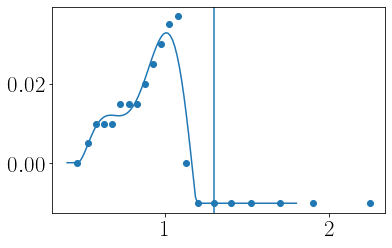

In [583]:
plt.scatter([.46, .525, .575, .625, .675, .725, .775, .825, .875, .925, .975, 1.025, 1.075, 1.125, 1.2, 1.3, 1.4, 1.525, 1.7, 1.9, 2.25], [0, .005, .01, .01, .01, .015, .015, .015, .02, .025, .03, .035, 0.037, 0, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01])
x = np.linspace(0.4, 1.8, 101)
plt.plot(x, np.select([(x<0.46),(x>=0.46)& (x<1.188), (x>=1.188)], [0.000164, p(x), -0.0100263]))
plt.axvline(1.3)

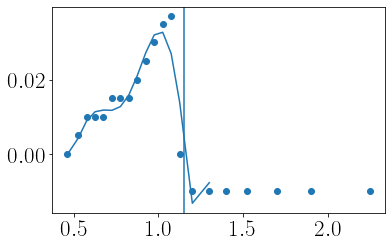

In [590]:
x, y = [.46, .525, .575, .625, .675, .725, .775, .825, .875, .925, .975, 1.025, 1.075, 1.125, 1.2, 1.3, 1.4, 1.525, 1.7, 1.9, 2.25], [0, .005, .01, .01, .01, .015, .015, .015, .02, .025, .03, .035, 0.037, 0, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01]
plt.scatter(x, y)
z = np.polyfit(x[:-5], y[:-5], deg = 6)
p = np.poly1d([29.076, -143.194, 285.466, -294.795, 166.302, -48.553, 5.731])
plt.plot(x[:-5], np.poly1d([29.076, -143.194, 285.466, -294.795, 166.302, -48.553, 5.731])(x[:-5]))
plt.axvline(1.15)

In [628]:
np.poly1d([29.076, -143.194, 285.466, -294.795, 166.302, -48.553, 5.731])(1.191)

-0.010089120338490964

In [542]:
(0.03073257+0.035)/ (1.2-1.025)

0.37561468571428563

In [444]:
-(0.03073257+0.035)/ (1.2-1.025)*1.2 + (0.03073257+0.035)/ (1.2-1.025)*1.2-0.035

-0.035

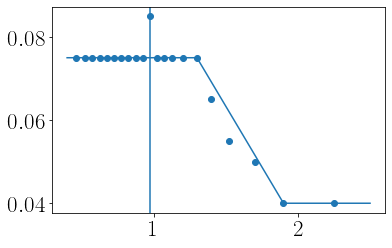

In [235]:
plt.scatter([.46, .525, .575, .625, .675, .725, .775, .825, .875, .925, .975, 1.025, 1.075, 1.125, 1.2, 1.3, 1.4, 1.525, 1.7, 1.9, 2.25], [.075, .075, .075, .075, .075,.075, .075, .075, .075, .075, .085, .075, .075, .075, .075, .075, .065, .055, .05, .04, .04])
x = np.linspace(0.4, 2.5, 101)
plt.plot(x, np.select([x<1.3, (x>=1.3) & (x<1.9), x>=1.9], [0.075, -7/120*x+7*1.9/120+0.04, 0.04]))
plt.axvline(0.975)

In [219]:
len([.46, .525, .575, .625, .675, .725, .775, .825, .875, .925, .975, 1.025, 1.075, 1.125, 1.2, 1.3, 1.4, 1.525, 1.7, 1.9, 2.25])

21

In [198]:
len([.075, .075, .075, .075, .075, .075,.075, .075, .075, .075, .085, .075, .075, .075, .075, .075, .065, .055, .05, .04, .04, .04])

22

In [237]:
parent_MC = "/Volumes/Extreme SSD/nov2021/convPkl_FDrevisited/outb/dvcs/"
parent_MC_bkg1g = "/Volumes/Extreme SSD/nov2021/convPkl_FDrevisited/outb/bkg_1g/"
parent_MC_bkg2g = "/Volumes/Extreme SSD/nov2021/convPkl_FDrevisited/outb/bkg_2g/"
parent_exp = "/Volumes/Extreme SSD/Jan2022/convPkl_outb/exp/"
# parent_exp = "/Volumes/Extreme SSD/nov2021/convPkl_FDrevisited/outb/exp/"

df_4240_corr = pd.read_pickle(parent_MC + "4240_0.pkl")
df_4243_1g_corr = pd.read_pickle(parent_MC_bkg1g + "4243_0.pkl")
df_4243_2g_corr = pd.read_pickle(parent_MC_bkg2g + "4243_0.pkl")
exp_1g_corr = pd.read_pickle(parent_exp + "dvcs.pkl")
exp_2g_corr = pd.read_pickle(parent_exp + "pi0.pkl")

In [238]:
epgExpOutb = copy(exp_1g_corr)
pi0ExpOutb = copy(exp_2g_corr)
dvcsSimOutb = df_4240_corr
bkgSimOutb = df_4243_1g_corr
pi0SimOutb = df_4243_2g_corr

In [239]:
epgExpOutbCDFT = epgExpOutb.loc[epgExpOutb.config == 3]
dvcsSimOutbCDFT = dvcsSimOutb.loc[dvcsSimOutb.config == 3]
bkgSimOutbCDFT = bkgSimOutb.loc[bkgSimOutb.config == 3]
pi0ExpOutbCDFT = pi0ExpOutb.loc[(pi0ExpOutb.config == 3)& (pi0ExpOutb.Pp < 0.8)]
pi0SimOutbCDFT = pi0SimOutb.loc[(pi0SimOutb.config == 3)& (pi0SimOutb.Pp < 0.8)]

epgExpOutbCD = epgExpOutb.loc[epgExpOutb.config == 2]
dvcsSimOutbCD = dvcsSimOutb.loc[dvcsSimOutb.config == 2]
bkgSimOutbCD = bkgSimOutb.loc[bkgSimOutb.config == 2]
pi0ExpOutbCD = pi0ExpOutb.loc[(pi0ExpOutb.config == 2)& (pi0ExpOutb.Pp < 0.8)]
pi0SimOutbCD = pi0SimOutb.loc[(pi0SimOutb.config == 2)& (pi0SimOutb.Pp < 0.8)]

epgExpOutbFD = epgExpOutb.loc[epgExpOutb.config == 1]
dvcsSimOutbFD = dvcsSimOutb.loc[dvcsSimOutb.config == 1]
bkgSimOutbFD = bkgSimOutb.loc[bkgSimOutb.config == 1]
pi0ExpOutbFD = pi0ExpOutb.loc[(pi0ExpOutb.config == 1)& (pi0ExpOutb.Pp < 0.8)]
pi0SimOutbFD = pi0SimOutb.loc[(pi0SimOutb.config == 1)& (pi0SimOutb.Pp < 0.8)]

In [240]:
contOutbCD = len(pi0ExpOutbCD)*len(bkgSimOutbCD)/len(pi0SimOutbCD)/len(epgExpOutbCD)
contOutbFD = len(pi0ExpOutbFD)*len(bkgSimOutbFD)/len(pi0SimOutbFD)/len(epgExpOutbFD)
contOutbCDFT = len(pi0ExpOutbCDFT)*len(bkgSimOutbCDFT)/len(pi0SimOutbCDFT)/len(epgExpOutbCDFT)
contOutb = len(pi0ExpOutb)*len(bkgSimOutb)/len(pi0SimOutb)/len(epgExpOutb)

In [241]:
x = np.linspace(0.4, 1, 101)

In [242]:
0.08-0.025*(np.abs(x-0.8) - (x-0.8))

array([0.06  , 0.0603, 0.0606, 0.0609, 0.0612, 0.0615, 0.0618, 0.0621,
       0.0624, 0.0627, 0.063 , 0.0633, 0.0636, 0.0639, 0.0642, 0.0645,
       0.0648, 0.0651, 0.0654, 0.0657, 0.066 , 0.0663, 0.0666, 0.0669,
       0.0672, 0.0675, 0.0678, 0.0681, 0.0684, 0.0687, 0.069 , 0.0693,
       0.0696, 0.0699, 0.0702, 0.0705, 0.0708, 0.0711, 0.0714, 0.0717,
       0.072 , 0.0723, 0.0726, 0.0729, 0.0732, 0.0735, 0.0738, 0.0741,
       0.0744, 0.0747, 0.075 , 0.0753, 0.0756, 0.0759, 0.0762, 0.0765,
       0.0768, 0.0771, 0.0774, 0.0777, 0.078 , 0.0783, 0.0786, 0.0789,
       0.0792, 0.0795, 0.0798, 0.08  , 0.08  , 0.08  , 0.08  , 0.08  ,
       0.08  , 0.08  , 0.08  , 0.08  , 0.08  , 0.08  , 0.08  , 0.08  ,
       0.08  , 0.08  , 0.08  , 0.08  , 0.08  , 0.08  , 0.08  , 0.08  ,
       0.08  , 0.08  , 0.08  , 0.08  , 0.08  , 0.08  , 0.08  , 0.08  ,
       0.08  , 0.08  , 0.08  , 0.08  , 0.08  ])

Pp 0.7096350284354493
reconGam 0.6582647729688168
coplanarity 5.148770745868075
Ptheta 34.60673263696994
MM2_epg -0.0011266886768263064
Pphi -1.5338388745125648
MM2_ep 0.020458492569163256
MPt 0.08277174253543271


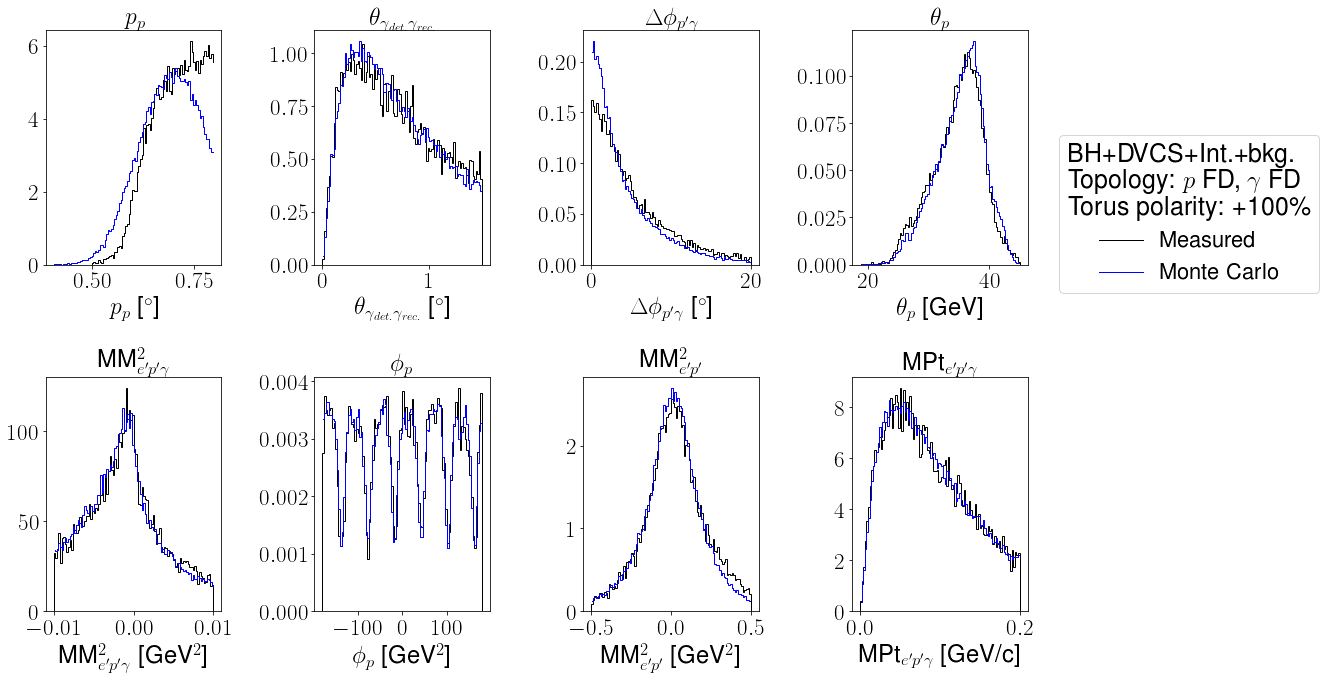

<Figure size 432x288 with 0 Axes>

In [245]:
df2 = bkgSimOutbFD#smearingDVCS4(bkgSimOutbFD, 0.08, 0, 0)
df1 = dvcsSimOutbFD#smearingDVCS4(dvcsSimOutbFD, 0.08, 0, 0)
df3 = epgExpOutbFD

df2 = smearingDVCS4(bkgSimOutbFD, 0.08, 0, 0)
df1 = smearingDVCS4(dvcsSimOutbFD, 0.08, 0, 0)
# df3 = correctDVCS4(epgExpOutbFD, 0, 0.05*(np.abs(epgExpOutbFD.Ptheta - 27) + (epgExpOutbFD.Ptheta - 27)), 0)

df3 = df3.loc[df3.Psector != df3.Gsector]
df2 = df2.loc[df2.Psector != df2.Gsector]
df1 = df1.loc[df1.Psector != df1.Gsector]

# Sector = 4
# df3 = df3.loc[df3.Psector == Sector, :]
# df2 = df2.loc[df2.Psector == Sector, :]
# df1 = df1.loc[df1.Psector == Sector, :]

df3 = df3.loc[(df3.Pp > 0.4) & (df3.Pp<0.8) & (df3.Ptheta>0)]
df2 = df2.loc[(df2.Pp > 0.4) & (df2.Pp<0.8) & (df2.Ptheta>0)]
df1 = df1.loc[(df1.Pp > 0.4) & (df1.Pp<0.8) & (df1.Ptheta>0)]
varstoplot = ["Pp", "reconGam", "coplanarity", "Ptheta", "MM2_epg", "Pphi", "MM2_ep", "MPt"]
title = [r"$p_p$", r"$\theta_{\gamma_{det.}\gamma_{rec.}}$", r"$\Delta\phi_{p'\gamma}$" , r"$\theta_p$", "MM"+r"${}^{2}_{e'p'\gamma}$", "$\phi_p$", "MM"+r"${}^{2}_{e'p'}$", "MPt"+r"${}_{e'p'\gamma}$"]
unit = [degree, degree, degree, GeV, GeV2, GeV2, GeV2, GeVc]
binstarts = [10, 0, 0, -0.5, -0.01, -180,-0.5 , 0]
binends = [40, 1.5, 20, 1.2, 0.01, 180, 0.5, 0.2]
fig, axs = plt.subplots(2, 4, figsize = (15,10))
for yind in range(0, 2):
    for xind in range(0,4):
        ind = 4*yind + xind
        start = binstarts[ind]
        end = binends[ind]
        bins = 100#np.linspace(start, end, 101)
        if ind in [1, 2, 4, 5, 6, 7] :
            bins = np.linspace(start, end, 101)
        simDist_dvpi0, bins = np.histogram(df2[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(df1[varstoplot[ind]], bins, density = True)
        simDist = (1-contOutbFD)*simDist_dvcs + contOutbFD*simDist_dvpi0
        expDist, bins = np.histogram(df3[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        if ind == 0:
            axs[yind, xind].step(bincenters, expDist, where='mid',color='k', linewidth=1, label = 'Measured')           
            axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1, label = 'Monte Carlo')  
            axs[yind, xind].set_ylim(bottom = 0)
        else:
            axs[yind, xind].hist(df3[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
            axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
        print(varstoplot[ind], nphistmean(expDist - len(pi0ExpOutbFD)/len(pi0SimOutbFD)*simDist_dvpi0, bins))
        axs[yind, xind].set_title(title[ind])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
plt.tight_layout()
fig.legend(bbox_to_anchor = (1.25, 0.8), title = "BH+DVCS+Int.+bkg.\nTopology: "+r"$p$"+" FD, "+r"$\gamma$"+" FD\n"+"Torus polarity: +100\%")
plt.show()
plt.clf()

In [246]:
pi0ExpOutbFD = pi0ExpOutb.loc[(pi0ExpOutb.config == 1)]
pi0SimOutbFD = pi0SimOutb.loc[(pi0SimOutb.config == 1)]

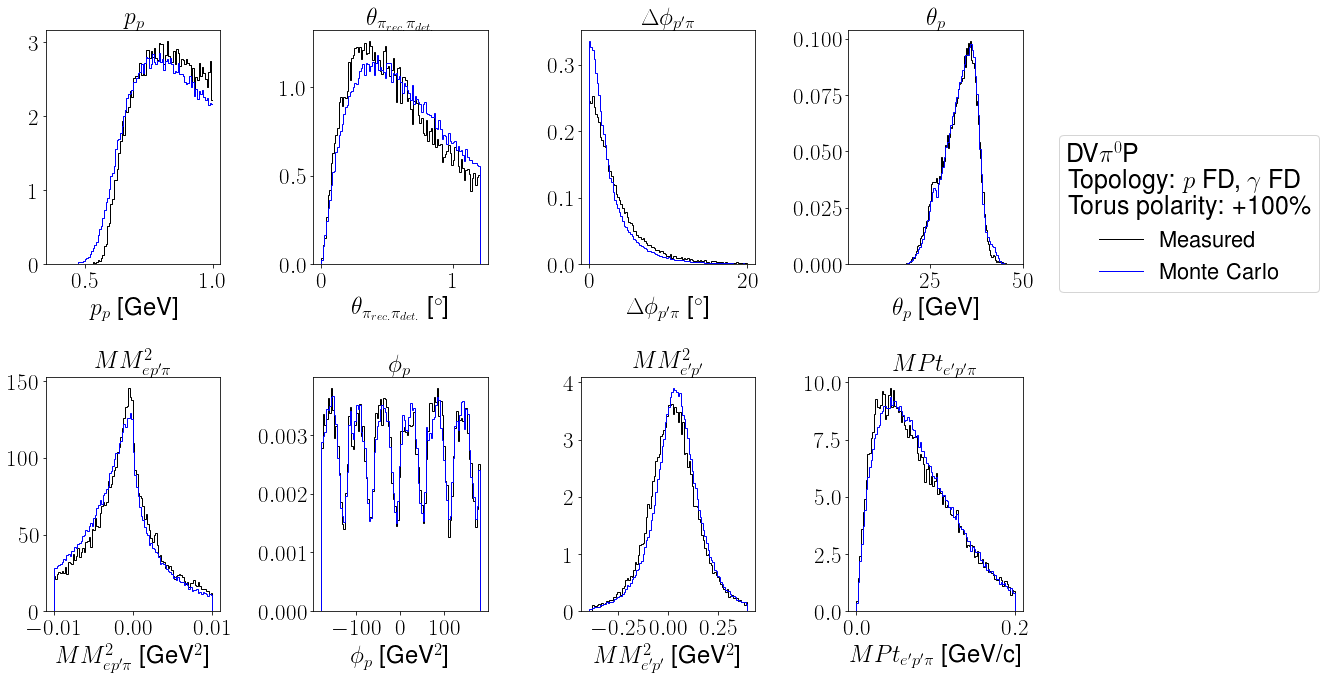

In [414]:
df2 = pi0SimOutbFD#smearingDVPi0P4(pi0SimOutbFD, 0.08, 0, 0)
df3 = pi0ExpOutbFD#correctDVPi0P4(pi0ExpOutbFD, 0, 0, 0)
# df2 = smearingDVPi0P4(pi0SimOutbFD,  np.select([df2.Pp<0.85, (df2.Pp>=0.85) & (df2.Pp<1.8), df2.Pp>=1.8], [0.08, -0.04/(1.8-0.85)*df2.Pp+1.8*0.04/(1.8-0.85) + 0.04, 0.04]), 0, 0) 
                      #np.select([df2.Pp<1.3, (df2.Pp>=1.3) & (df2.Pp<1.9), df2.Pp>=1.9], [0.075, -7/120*df2.Pp+7*1.9/120+0.04, 0.04]), 0, 0)
# df2 = smearingDVPi0P4(df2, 0.07, 0, 0)
# df2 = smearingDVPi0P4(pi0SimOutbFD, np.select([df2.Pp<0.925, (df2.Pp>=0.925) & (df2.Pp<2.25), df2.Pp>= 2.25], [0.08, 0.02092048*df2.Pp*df2.Pp -0.09476737*df2.Pp + 0.14847771, 0.04]), 0, 0)    

df2 = smearingDVPi0P4(df2, np.select([df2.Pp<.95, (df2.Pp>=.95) & (df2.Pp<1.2), (df2.Pp>=1.2)&(df2.Pp<1.575), (df2.Pp>=1.575) & (df2.Pp<1.9), (df2.Pp>1.9)], [0.075, -0.02/(1.2-.95)*df2.Pp+1.2*0.02/(1.2-.95) + 0.055, 0.055, -0.015/(1.9-1.575)*df2.Pp+1.9*0.015/(1.9-1.575) + 0.04,0.04]), 0, 0)
df3 = df3.loc[df3.Psector != df3.Gsector]
df3 = df3.loc[df3.Psector != df3.Gsector2]
df2 = df2.loc[df2.Psector != df2.Gsector]
df2 = df2.loc[df2.Psector != df2.Gsector2]
df3 = df3.loc[(df3.Pp < 1)& (df3.Pp < 1.5) ]
df2 = df2.loc[(df2.Pp < 1)& (df2.Pp < 1.5) ]
varstoplot = ["Pp", "reconPi", "coplanarity", "Ptheta", "MM2_epgg", "Pphi", "MM2_ep", "MPt"]
title = [r"$p_p$", r"$\theta_{\pi_{rec.}\pi_{det.}}$", r"$\Delta\phi_{p'\pi}$", r"$\theta_p$", r"$MM^2_{ep'\pi}$", r"$\phi_p$", r"$MM^{2}_{e'p'}$", r"$MPt_{e'p'\pi}$" ]
unit = [GeV, degree, degree, GeV, GeV2, GeV2, GeV2, GeVc]
binstarts = [0, 0, 0, -0.5, -0.01, -180,-0.4 , 0]
binends = [0.8, 1.2, 20, 1.2, 0.01, 180, 0.4, 0.2]
fig, axs = plt.subplots(2, 4, figsize = (15, 10))
for xind in range(0,4):
    for yind in range(0, 2):
        ind =xind+4*yind
        start = binstarts[ind]
        end = binends[ind]
        bins = 100#np.linspace(start, end, 101)
        if ind in [1, 2, 4, 5, 6, 7] :
            bins = np.linspace(start, end, 101)
        if ind == 0 :
            simDist_dvpi0, bins = np.histogram(df2[varstoplot[ind]], bins, density = True)
            simDist = simDist_dvpi0
            expDist, bins = np.histogram(df3[varstoplot[ind]], bins, density=True)
            bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
            axs[yind, xind].step(bincenters, expDist, where='mid',color='k', linewidth=1, label = 'Measured')           
            axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1, label = 'Monte Carlo')           
            axs[yind, xind].set_ylim(bottom = 0)
        else:
            axs[yind, xind].hist(df3.loc[:, varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
            axs[yind, xind].hist(df2.loc[:, varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='b', density=True, linewidth=1)
        axs[yind, xind].set_title(title[ind])
#         axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
plt.tight_layout()
fig.legend(bbox_to_anchor = (1.25, 0.8), title = "DV"+r"$\pi^0$"+"P\nTopology: "+r"$p$"+" FD, "+r"$\gamma$"+" FD\n"+"Torus polarity: +100\%")
plt.show()

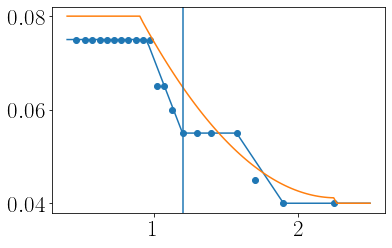

In [402]:
plt.scatter([.46, .525, .575, .625, .675, .725, .775, .825, .875, .925, .975, 1.025, 1.075, 1.125, 1.2, 1.3, 1.4, 1.575, 1.7, 1.9, 2.25], [.075, .075, .075, .075, .075, .075, .075, .075, .075, .075, .075, .065, .065, .06, .055, .055, .055, .055, .045, .04, .04])
x = np.linspace(0.4, 2.5, 101)
plt.plot(x, np.select([x<.95, (x>=.95) & (x<1.2), (x>=1.2)&(x<1.575), (x>=1.575) & (x<1.9), (x>1.9)], [0.075, -0.02/(1.2-.95)*x+1.2*0.02/(1.2-.95) + 0.055, 0.055, -0.015/(1.9-1.575)*x+1.9*0.015/(1.9-1.575) + 0.04,0.04]))
plt.plot(x, np.select([x<0.925, (x>=0.925) & (x<2.25), x>= 2.25], [0.08, 0.02092048*x*x -0.09476737*x + 0.14847771, 0.04]))

plt.axvline(1.2)

In [358]:
x = [.925, .975, 1.025, 1.075, 1.125, 1.2, 1.3, 1.4, 1.525, 1.7, 1.9, 2.25]
y = [.08, .075, .075, .07, .07, .065, .055, .055, .055, .05, .045, .04]
np.polyfit(x, y ,3)

array([-0.02098329,  0.12004582, -0.24377848,  0.2196739 ])

<AxesSubplot:>

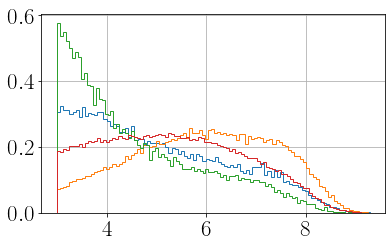

In [346]:
epgExpInbFD.Gp.hist(bins = 101, density = True, histtype = 'step')
epgExpInbCD.Gp.hist(bins = 101, density = True, histtype = 'step')

epgExpOutbFD.Gp.hist(bins = 101, density = True, histtype = 'step')
epgExpOutbCD.Gp.hist(bins = 101, density = True, histtype = 'step')

<AxesSubplot:>

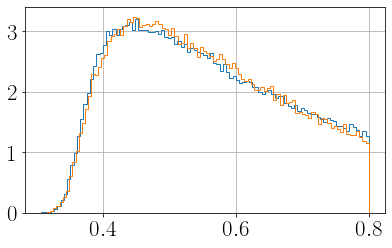

In [58]:
dvcsSimInbCD.Pp.hist(bins = 101, density = True, histtype = 'step')
(epgExpInbCD.Pp).hist(bins = 101, density = True, histtype = 'step')

# epgExpOutbFD.Gp.hist(bins = 101, density = True, histtype = 'step')
# epgExpOutbCD.Gp.hist(bins = 101, density = True, histtype = 'step')

In [230]:
parent_MC = "/Volumes/Extreme SSD/nov2021/convPkl/dvcs/"
parent_MC_bkg1g = "/Volumes/Extreme SSD/nov2021/convPkl/bkg_1g/"
parent_MC_bkg2g = "/Volumes/Extreme SSD/nov2021/convPkl/bkg_2g/"
parent_exp = "/Volumes/Extreme SSD/nov2021/convPkl/exp/"

df_3987_corr = pd.read_pickle(parent_MC + "3987.pkl")
df_4076_1g_corr = pd.read_pickle(parent_MC_bkg1g + "4076.pkl")
df_4076_2g_corr = pd.read_pickle(parent_MC_bkg2g + "4076.pkl")
exp_1g_corr = pd.read_pickle(parent_exp + "dvcs.pkl")
# exp_2g_corr = pd.read_pickle(parent_exp + "pi0.pkl")

In [231]:
epgExpInb = copy(exp_1g_corr)
pi0ExpInb = copy(exp_2g_corr)
dvcsSimInb = copy(df_3987_corr)
bkgSimInb = copy(df_4076_1g_corr)
pi0SimInb = copy(df_4076_2g_corr)

In [232]:
epgExpInbCDFT = epgExpInb.loc[(exp_1g_corr.Ee>2)&(exp_1g_corr.Ge>3)&(exp_1g_corr.Pp>0.25)&(exp_1g_corr.Pp<0.8)&((exp_1g_corr.Psector>7)&(exp_1g_corr.Ptheta<60))& (exp_1g_corr.Gsector>7)]
pi0ExpInbCDFT = pi0ExpInb.loc[(exp_2g_corr.Ee>2)&(exp_2g_corr.Ge>3)&(exp_2g_corr.Pp>0.25)&(exp_2g_corr.Pp<0.8)&((exp_2g_corr.Psector>7)&(exp_2g_corr.Ptheta<60))& (exp_2g_corr.Gsector>7)& (exp_2g_corr.Gsector2>7)]
dvcsSimInbCDFT = dvcsSimInb.loc[(dvcsSimInb.Ee>2)&(dvcsSimInb.Ge>3)&(dvcsSimInb.Pp>0.25)&(dvcsSimInb.Pp<0.8)&((dvcsSimInb.Psector>7)&(dvcsSimInb.Ptheta<60))& (dvcsSimInb.Gsector>7)]
bkgSimInbCDFT = bkgSimInb.loc[(bkgSimInb.Ee>2)&(bkgSimInb.Ge>3)&(bkgSimInb.Pp>0.25)&(bkgSimInb.Pp<0.8)&((bkgSimInb.Psector>7)&(bkgSimInb.Ptheta<60))& (bkgSimInb.Gsector>7)]
pi0SimInbCDFT = pi0SimInb.loc[(pi0SimInb.Ee>2)&(pi0SimInb.Ge>3)&(pi0SimInb.Pp>0.25)&(pi0SimInb.Pp<0.8)&((pi0SimInb.Psector>7)&(pi0SimInb.Ptheta<60))& (pi0SimInb.Gsector>7)]

In [233]:
epgExpInbCD = copy(exp_1g_corr.loc[(exp_1g_corr.Ee>2)&(exp_1g_corr.Ge>3)&(exp_1g_corr.Pp>0.25)&(exp_1g_corr.Pp<0.8)&((exp_1g_corr.Psector>7)&(exp_1g_corr.Ptheta<60))& (exp_1g_corr.Gsector<7)])
pi0ExpInbCD = copy(exp_2g_corr.loc[(exp_2g_corr.Ee>2)&(exp_2g_corr.Ge>3)&(exp_2g_corr.Pp>0.25)&(exp_2g_corr.Pp<0.8)&((exp_2g_corr.Psector>7)&(exp_2g_corr.Ptheta<60))& (exp_2g_corr.Gsector<7)& (exp_2g_corr.Gsector2<7)])
dvcsSimInbCD = copy(dvcsSimInb.loc[(dvcsSimInb.Ee>2)&(dvcsSimInb.Ge>3)&(dvcsSimInb.Pp>0.25)&(dvcsSimInb.Pp<0.8)&((dvcsSimInb.Psector>7)&(dvcsSimInb.Ptheta<60))& (dvcsSimInb.Gsector<7)])
bkgSimInbCD = copy(bkgSimInb.loc[(bkgSimInb.Ee>2)&(bkgSimInb.Ge>3)&(bkgSimInb.Pp>0.25)&(bkgSimInb.Pp<0.8)&((bkgSimInb.Psector>7)&(bkgSimInb.Ptheta<60))& (bkgSimInb.Gsector<7)])
pi0SimInbCD = copy(pi0SimInb.loc[(pi0SimInb.Ee>2)&(pi0SimInb.Ge>3)&(pi0SimInb.Pp>0.25)&(pi0SimInb.Pp<0.8)&((pi0SimInb.Psector>7)&(pi0SimInb.Ptheta<60))& (pi0SimInb.Gsector<7)])

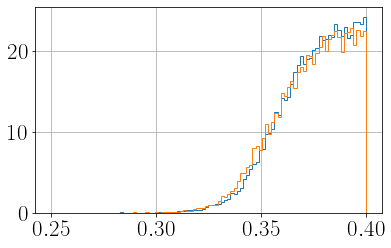

In [234]:
dvcsSimInbCDFT.Pp.hist(bins = np.linspace(0.25, 0.4, 101), density = True, histtype = 'step')
(epgExpInbCDFT.Pp+0.01).hist(bins = np.linspace(0.25, 0.4, 101), density = True, histtype = 'step')
plt.show()

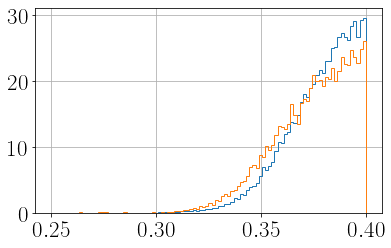

In [119]:
dvcsSimInbCD.Pp.hist(bins = np.linspace(0.25, 0.4, 101), density = True, histtype = 'step')
epgExpInbCD.Pp.hist(bins = np.linspace(0.25, 0.4, 101), density = True, histtype = 'step')
plt.show()